# Problem Set #3
- MACS 40200, Dr. Evans 
- Name: Kento Yoshizawa (CNET: kyoshizawa) 
- Date: February 10, 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as intgr
import scipy.optimize as opt
from scipy import stats, special
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Question 1.

In [2]:
income = np.loadtxt('data/hh_inc_synth.txt')
income.shape

(121085,)

### (a) Create the moments

In [3]:
bins = np.arange(0, 2e+5+1, step = 5000)
bins = np.append(bins, [2.5e+5, 3.5e+5])

In [4]:
def hist_weights(data, width):
    weights = np.ones_like(data)/(data.shape[0]*width)
    weights[(data >= 2e+5) & (data < 2.5e+5)] = 1/(data.shape[0]*width*10)
    weights[data >= 2.5e+5] = 1/(data.shape[0]*width*20)
    
    return weights

In [5]:
w_rel = hist_weights(income, width = 1)
counts, _ = np.histogram(income,bins = bins)
pct,    _ = np.histogram(income,bins = bins, weights = w_rel)

In [6]:
print('Histogram counts moments:\n {}'.format(counts))
print('\nHistogram percentages moments:\n {}'.format(pct*100))

Histogram counts moments:
 [4261 4972 7127 6882 7095 6591 6667 6136 5795 4945 5170 4250 4432 3836
 3606 3452 3036 2566 2594 2251 2527 1771 1723 1569 1540 1258 1211  918
 1031  893 1166  740  697  610  617  530  460  363  380  312 2297 2808]

Histogram percentages moments:
 [3.51901557 4.10620638 5.88594789 5.68361069 5.85952017 5.44328364
 5.50604947 5.06751456 4.78589421 4.083908   4.26972788 3.50993104
 3.66023868 3.16802246 2.97807325 2.85088987 2.50732956 2.11917248
 2.14229673 1.85902465 2.0869637  1.46260891 1.42296734 1.29578395
 1.27183384 1.03893959 1.00012388 0.7581451  0.85146798 0.73749845
 0.9629599  0.61114093 0.57562869 0.50377834 0.5095594  0.43770905
 0.37989842 0.2997894  0.31382913 0.25767023 0.18970145 0.1159516 ]


### (b) Plot the histogram of the data

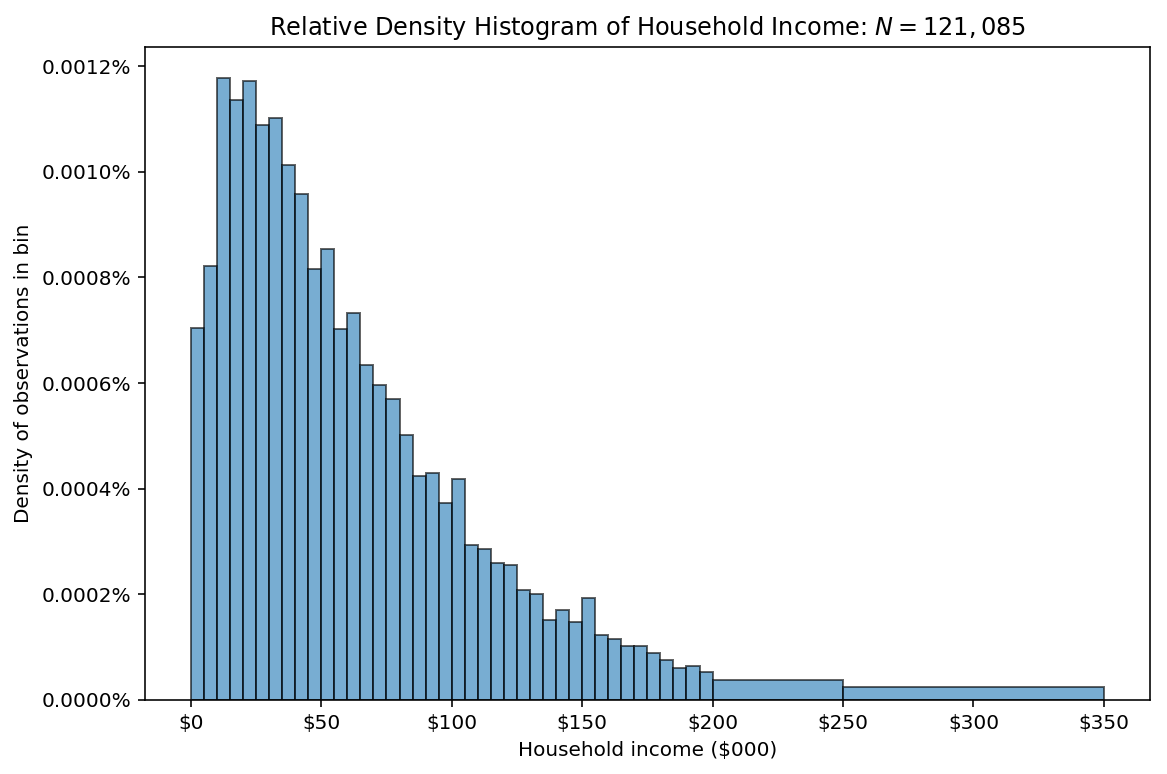

In [7]:
from matplotlib.ticker import FuncFormatter

w_den = hist_weights(income, 5000)

fig,ax = plt.subplots(figsize = (9,6))

plt.title('Relative Density Histogram of Household Income: $N = {:,}$'.format(income.shape[0]))
c, b, _ = ax.hist(income, bins = bins, weights = w_den, edgecolor = 'k',alpha = 0.6)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:.4%}'.format(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${0:.3g}'.format(x/1000)))
ax.set_ylabel('Density of observations in bin')
ax.set_xlabel('Household income ($000)');

### (c) Fit Lognormal dist
####  Specification of the model
The model we want to fit and estimate parameters is the lognormal $LN(x;\mu,\sigma)$ distribution.

$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$


In [8]:
def lognorm_pdf(xvals, mu, sigma):
    pdf_vals = (1 / (xvals * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(xvals) - mu)**2 / (2 * sigma ** 2)))
    pdf_vals[]
    return pdf_vals

#### Specification of the moments and moment error function

We use the relative frequencies of the household income distribution as the moments.

In [9]:
def data_moments(xvals, bins):
    weights = np.ones_like(xvals)/(xvals.shape[0])        
    moments, b = np.histogram(xvals, bins = bins, weights = weights)
    
    return moments

In [10]:
def ln_moments(mu, sigma, bins):
    model_moms = []
    
    for i in range(len(bins)-1):
        fx = lambda x: lognorm_pdf(x, mu, sigma)
        (mom, m_err) = intgr.quad(fx, bins[i], bins[i+1])
        model_moms.append(mom)
        
    return np.array(model_moms)

In [11]:
def ln_err_vec(xvals, mu, sigma, bins, simple):
    data_moms = data_moments(xvals, bins)
    
    model_moms = ln_moments(mu, sigma, bins)
    
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    
    return err_vec

#### Performing GMM estimation

Perform GMM estimation with the $42 \times 42$ diagonal matrix in which the diagonal elements are the data moments.

In [12]:
def criterion_ln(params, *args):
    mu, sigma = params
    xvals, bins, W = args
    err = ln_err_vec(xvals, mu, sigma, bins, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [13]:
## Set 42 * 42 diagonal matrix in which 
## the diagonal elements are the data moments
W_hat = np.diag(data_moments(income, bins))
W_hat.shape

(42, 42)

In [14]:
## Set GMM arguments
gmm_args = (income, bins, W_hat)

Try several initial guesses.

In [15]:
## Initial guess 1
mu_init = 5.0
sig_init = 0.5
params_init = np.array([mu_init, sig_init])

## Optimization
results_ln = opt.minimize(criterion_ln, params_init, args=(gmm_args))
results_ln

      fun: 27.417038253874765
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0.00000000e+00, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([5. , 0.5])

In [16]:
## Initial guess 2
mu_init =  1.0
sig_init = 0.1
params_init = np.array([mu_init, sig_init])

## Optimization
results_ln = opt.minimize(criterion_ln, params_init, args=(gmm_args))
results_ln

      fun: 0.9999999991226305
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-5.96046448e-08, -4.02331352e-07])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1. , 0.1])

In [17]:
## Initial guess 3
mu_init = np.log(np.mean(income))
sig_init = 0.5
params_init = np.array([mu_init, sig_init])

## Optimization
results_ln = opt.minimize(criterion_ln, params_init, args=(gmm_args))
results_ln

      fun: 0.03551647937231729
 hess_inv: array([[ 0.55704963, -0.07260388],
       [-0.07260388,  0.58736437]])
      jac: array([-6.01634383e-07,  6.63567334e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([10.80120052,  0.97573685])

Starting with $\mu_0 = \ln(avg.inc.)$ seems to be good for the estimation. Thus, the results for the GMM estimation are the following:

In [18]:
# mu_GMM, sig_GMM = results_ln.x
print('Estimated values\n  - mu   : {0:.4f}\n  - sigma: {1:.4f}'.format(*results_ln.x))
print('The value of the minimized criterion function: {0:.4f}'.format(results_ln.fun))

Estimated values
  - mu   : 10.8012
  - sigma: 0.9757
The value of the minimized criterion function: 0.0355


#### Plotting the distribution implied from GMM estimation of the model

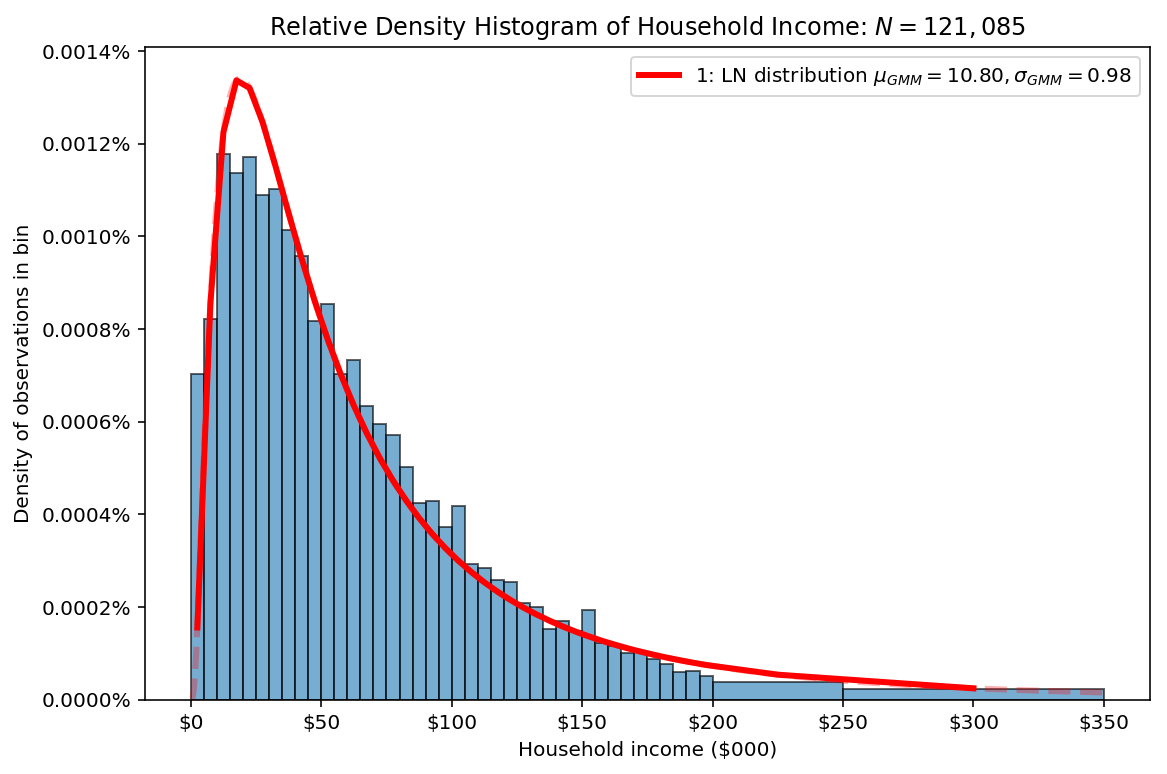

In [19]:
midpoint = (bins[1:]+bins[:-1])/2
xaxis = np.linspace(1e-7,3.5e+5,1000)

fig,ax = plt.subplots(figsize = (9,6))

plt.title('Relative Density Histogram of Household Income: $N = {:,}$'.format(income.shape[0]))
## Histogram from data
c, b, _ = ax.hist(income, bins = bins, weights = w_den, 
                  edgecolor = 'k',alpha = 0.6)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:.4%}'.format(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${0:.3g}'.format(x/1000)))
ax.set_ylabel('Density of observations in bin')
ax.set_xlabel('Household income ($000)')

## Overlaying
ax.plot(midpoint, lognorm_pdf(midpoint, *results_ln.x), linewidth = 3, c = 'r', 
        label = r'1: LN distribution $\mu_{{GMM}} = {0:.2f}, \sigma_{{GMM}} = {1:.2f}$'.format(*results_ln.x))
ax.plot(xaxis, lognorm_pdf(xaxis, *results_ln.x), linewidth = 3, c = 'r',ls = '--',alpha = 0.3)

plt.legend();

### (d) Fit Gamma dist
####  Specification of the model
The model we want to fit and estimate parameters is the gamma $GA(x;\mu,\sigma)$ distribution.

$$ 
\begin{align}
\text{(GA):}\quad f(x;\alpha,\beta) &= \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 \\
&\text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt
\end{align}
$$


In [20]:
def ga_pdf(xvals, alpha, beta): 
    pdf_vals = (1 / ((beta ** alpha) * special.gamma(alpha))) * (xvals ** (alpha - 1)) * (np.exp(-xvals/beta))
    
    return pdf_vals

#### Specification of the moments and moment error function

In [21]:
def ga_moments(alpha, beta, bins):
    model_moms = []
    
    for i in range(len(bins)-1):
        fx = lambda x: ga_pdf(x, alpha, beta)
        (mom, m_err) = intgr.quad(fx, bins[i], bins[i+1], limit = 3000)
        model_moms.append(mom)
        
    return np.array(model_moms)

In [22]:
def ga_err_vec(xvals, alpha, beta, bins, simple):
    data_moms = data_moments(xvals, bins)
    
    model_moms = ga_moments(alpha, beta, bins)
    
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    
    return err_vec

#### Performing GMM estimation

Perform GMM estimation with the $42 \times 42$ diagonal matrix in which the diagonal elements are the data moments.

In [23]:
def criterion_ga(params, *args):
    alpha, beta = params
    xvals, bins, W = args
    err = ga_err_vec(xvals, alpha, beta, bins, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [24]:
## Initial guess
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])

## Optimization
results_ga = opt.minimize(criterion_ga, params_init, args=(gmm_args))
results_ga

      fun: 0.014084919216431332
 hess_inv: array([[ 1.80748881e+00, -7.27451848e+04],
       [-7.27451848e+04,  3.94109808e+09]])
      jac: array([-1.75554305e-07, -3.49245965e-10])
  message: 'Optimization terminated successfully.'
     nfev: 184
      nit: 45
     njev: 46
   status: 0
  success: True
        x: array([1.36708363e+00, 4.80614226e+04])

In [25]:
# alpha_GMM, beta_GMM = results_ga.x
print('Estimated values\n  - alpha: {0:.4f}\n  - beta : {1:.4f}'.format(*results_ga.x))
print('The value of the minimized criterion function: {0:.4f}'.format(results_ga.fun))

Estimated values
  - alpha: 1.3671
  - beta : 48061.4226
The value of the minimized criterion function: 0.0141


#### Plotting the distribution implied from GMM estimation of the model

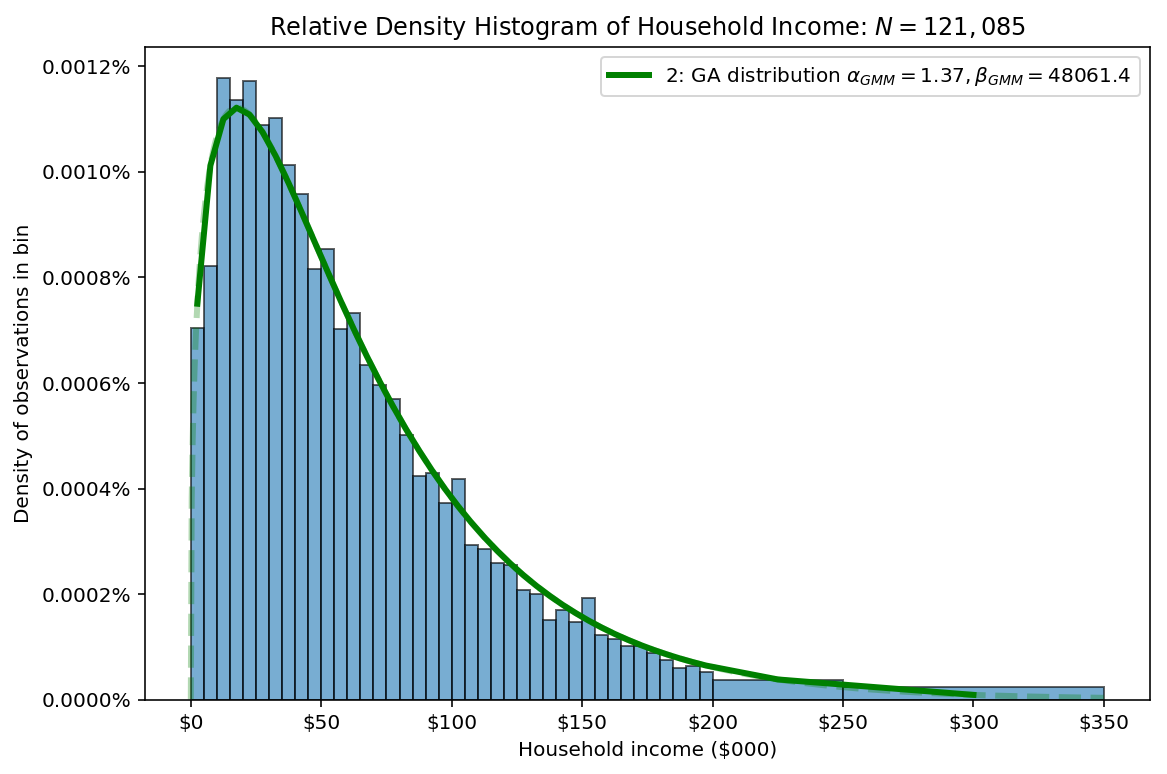

In [26]:
fig,ax = plt.subplots(figsize = (9,6))

plt.title('Relative Density Histogram of Household Income: $N = {:,}$'.format(income.shape[0]))
## Histogram from data
c, b, _ = ax.hist(income, bins = bins, weights = w_den, 
                  edgecolor = 'k',alpha = 0.6)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:.4%}'.format(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${0:.3g}'.format(x/1000)))
ax.set_ylabel('Density of observations in bin')
ax.set_xlabel('Household income ($000)')

## Overlaying
ax.plot(midpoint, ga_pdf(midpoint, *results_ga.x), linewidth = 3, c = 'g', 
        label = r'2: GA distribution $\alpha_{{GMM}} = {0:.2f}, \beta_{{GMM}} = {1:.1f}$'.format(*results_ga.x))
ax.plot(xaxis, ga_pdf(xaxis, *results_ga.x), linewidth = 3, c = 'g',ls = '--',alpha = 0.3)

plt.legend();

### (e) Compare LN and GA

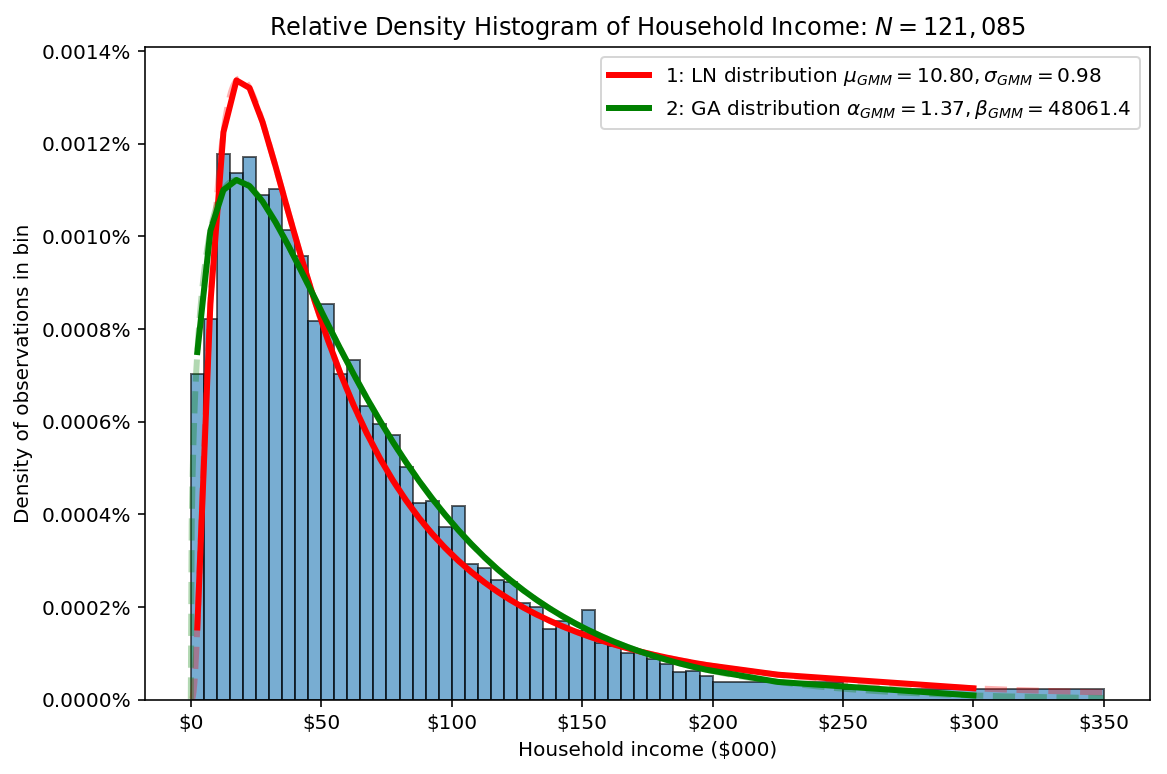

In [27]:
fig,ax = plt.subplots(figsize = (9,6))

plt.title('Relative Density Histogram of Household Income: $N = {:,}$'.format(income.shape[0]))
## Histogram from data
c, b, _ = ax.hist(income, bins = bins, weights = w_den, 
                  edgecolor = 'k',alpha = 0.6)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:.4%}'.format(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${0:.3g}'.format(x/1000)))
ax.set_ylabel('Density of observations in bin')
ax.set_xlabel('Household income ($000)')

## Overlaying
ax.plot(midpoint, lognorm_pdf(midpoint, *results_ln.x), linewidth = 3, c = 'r', 
        label = r'1: LN distribution $\mu_{{GMM}} = {0:.2f}, \sigma_{{GMM}} = {1:.2f}$'.format(*results_ln.x))
ax.plot(xaxis, lognorm_pdf(xaxis, *results_ln.x), linewidth = 3, c = 'r',ls = '--',alpha = 0.3)
ax.plot(midpoint, ga_pdf(midpoint, *results_ga.x), linewidth = 3, c = 'g', 
        label = r'2: GA distribution $\alpha_{{GMM}} = {0:.2f}, \beta_{{GMM}} = {1:.1f}$'.format(*results_ga.x))
ax.plot(xaxis, ga_pdf(xaxis, *results_ga.x), linewidth = 3, c = 'g',ls = '--',alpha = 0.3)

plt.legend();

The plot seems that GA distribution is better to fit the data than LN distribution. 

Also, since we use the same weighting matrix for the GMM estimation in the both models, comparing the value of the minimized criterion function is the most precise way to tell how the model fits the data. Indeed, the value from GA distribution (0.0141) is smaller than that from LN distribution (0.0355).

### (f) Two-step estimate

#### First step
estimate the GMM parameters $\hat{\alpha}_{1,GMM}, \hat{\beta}_{1,GMM}$ using the simple identity matrix as the weighting matrix $W = I$.

In [28]:
## Initial guess
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])

## Set GMM arguments
W_hat2_1 = np.eye(42)
gmm_args2_1 = (income, bins, W_hat2_1)

## Optimization
results_ga2_1 = opt.minimize(criterion_ga, params_init, args=(gmm_args2_1))
results_ga2_1

      fun: 0.7388928796814497
 hess_inv: array([[ 5.00270068e-02, -1.54860725e+03],
       [-1.54860725e+03,  5.82790225e+07]])
      jac: array([-6.85453415e-07, -7.45058060e-09])
  message: 'Optimization terminated successfully.'
     nfev: 144
      nit: 29
     njev: 36
   status: 0
  success: True
        x: array([1.37437720e+00, 4.62108719e+04])

#### Second step

Calculate $E(x|\alpha, \beta)$ and use it to obtain the estimated variance-covariance matrix of the moment vector. Then we can have $\hat{W}_{Twostep}$.

In [30]:
def ga_Err_mat(xvals, alpha, beta, bins, simple):
    N = len(xvals)
    R = len(bins)-1
    
    Err_mat = np.zeros((R, N))
    model_mom = ga_moments(alpha, beta, bins)
    
    for r in range(R):
        group = ((xvals >= bins[r]) & (xvals < bins[r+1]))
        if simple:
            Err_mat[r,:] = (model_mom[r] - group)
        else:
            Err_mat[r,:] = (model_mom[r]- group) / group
    
    return Err_mat

In [31]:
Err_mat = ga_Err_mat(income, *results_ga2_1.x, bins, True)
VCV = (1 / income.shape[0]) * (Err_mat @ Err_mat.T)
W_hat2 = np.linalg.inv(VCV)
print('Two-step estimator for the optimal weighting matrix:\n', W_hat2)

Two-step estimator for the optimal weighting matrix:
 [[610421.09796908 610578.17639515 610343.17513095 ... 610474.17242322
  610314.80684181 609888.39229251]
 [610578.17639515 610788.0252384  610528.67059528 ... 610659.66788754
  610500.30230613 610073.88775684]
 [610343.17513095 610528.67059528 610310.65894803 ... 610424.66662334
  610265.30104193 609838.88649264]
 ...
 [610474.17242322 610659.66788754 610424.66662334 ... 610943.75686433
  610396.2983342  609969.8837849 ]
 [610314.80684181 610500.30230613 610265.30104193 ... 610396.2983342
  610289.64716289 609810.51820349]
 [609888.39229251 610073.88775684 609838.88649264 ... 609969.8837849
  609810.51820349 609427.22509294]]


#### Re-estimate GMM estimators

Re-estimate the GMM estimator using the optimal two-step weighting matrix.

In [32]:
## Initial guess
params_init = results_ga2_1.x

## Set GMM arguments
gmm_args2_2 = (income, bins, W_hat2)

## Optimization
results_ga2_2 = opt.minimize(criterion_ga, params_init, args=(gmm_args2_2),
                          method='L-BFGS-B', bounds=((1e-7, None), (1e-7, None)))
results_ga2_2

      fun: 53.24945343256791
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.38598679, 0.01665725])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 5
   status: 0
  success: True
        x: array([1.36223831e+00, 4.62082068e+04])

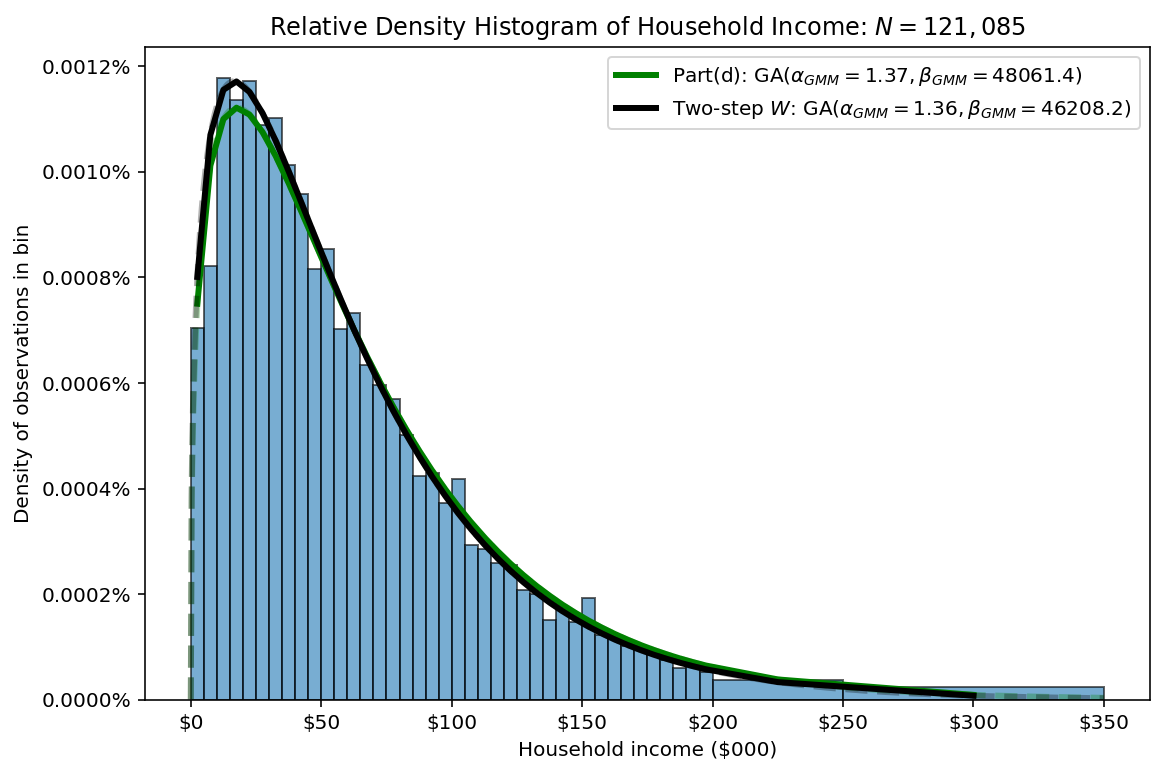

In [33]:
fig,ax = plt.subplots(figsize = (9,6))

plt.title('Relative Density Histogram of Household Income: $N = {:,}$'.format(income.shape[0]))
## Histogram from data
c, b, _ = ax.hist(income, bins = bins, weights = w_den, 
                  edgecolor = 'k',alpha = 0.6)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:.4%}'.format(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${0:.3g}'.format(x/1000)))
ax.set_ylabel('Density of observations in bin')
ax.set_xlabel('Household income ($000)')

## Overlaying
ax.plot(midpoint, ga_pdf(midpoint, *results_ga.x), linewidth = 3, c = 'g', 
        label = r'Part(d): GA($\alpha_{{GMM}} = {0:.2f}, \beta_{{GMM}} = {1:.1f})$'.format(*results_ga.x))
ax.plot(xaxis, ga_pdf(xaxis, *results_ga.x), linewidth = 3, c = 'g',ls = '--',alpha = 0.3)

ax.plot(midpoint, ga_pdf(midpoint, *results_ga2_2.x), linewidth = 3, c = 'k', 
        label = r'Two-step $W$: GA($\alpha_{{GMM}} = {0:.2f}, \beta_{{GMM}} = {1:.1f})$'.format(*results_ga2_2.x))
ax.plot(xaxis, ga_pdf(xaxis, *results_ga2_2.x), linewidth = 3, c = 'k',ls = '--',alpha = 0.3)

plt.legend();

The two-step estimator of the optimal weighting matrix is not so much different from the estimated $\alpha, \beta$ parameters with estimators in Part(d). Although we can't compare the values of the minimized criterion function for each estimation because the weighting matrix is different, the goodness of fit seems to be also very similar judging from the plot above.

#### Variance-covariance matrix

In [34]:
def Jac_err(xvals, params, args, simple = False):
    bins, err_vec_ = args
    R = len(bins)-1
    K = len(params)
    h = 1e-8
    
    Jac_err = np.zeros((R, K))
    for k in range(K):
        theta_ub = params.copy()
        theta_lb = params.copy()
        theta_ub[k] = (theta_ub[k] + theta_ub[k] * h)
        theta_lb[k] = (theta_lb[k] - theta_lb[k] * h)
        
        Jac_err[:,k] =\
                    ((err_vec_(xvals, *theta_ub, bins, simple) - \
                      err_vec_(xvals, *theta_lb, bins, simple)) / (2 * params[k] * h)).flatten()
    
    return Jac_err

In [35]:
args = (bins, ga_err_vec)
d_err  = Jac_err(income, results_ga.x, args)
d_err2 = Jac_err(income, results_ga2_2.x, args)
SigHat  = (1/income.shape[0]) * np.linalg.inv(d_err.T @ W_hat @ d_err)
SigHat2 = (1/income.shape[0]) * np.linalg.inv(d_err2.T @ W_hat2 @ d_err2)

In [36]:
print('Std. err of alpha_hat\n - Part(d) : {0:.6f}\n - Two-step: {1:.6f}'\
      .format(np.sqrt(SigHat[0,0]), np.sqrt(SigHat2[0,0])))
print('Std. err of beta_hat\n - Part(d) : {0:.3f}\n - Two-step: {1:.3f}'\
      .format(np.sqrt(SigHat[1,1]), np.sqrt(SigHat2[1,1])))

Std. err of alpha_hat
 - Part(d) : 0.005407
 - Two-step: 0.000130
Std. err of beta_hat
 - Part(d) : 242.144
 - Two-step: 4.029


The standard errors of parameters with the two-step weighting matrix is much smaller than those in Part(d).

---
## Question 2.

In [37]:
macro = np.loadtxt('data/MacroSeries.txt', delimiter=',')
macro.shape

(100, 4)

In [38]:
ct = macro[:,0]
kt = macro[:,1]
wt = macro[:,2]
rt = macro[:,3]

### (a)

In [39]:
def tfp_zt(rt, kt, alpha):
    zt =  np.log(rt) - np.log(alpha * kt ** (alpha - 1))
    
    return zt

In [40]:
def BMmodel_moments(params, args):
    alpha, rho, mu = params
    ct, kt, wt, rt = args
    beta = 0.99
    
    zt = tfp_zt(rt, kt, alpha)
    
    m1 = zt[1:] - rho * zt[:-1] - (1 - rho) * mu
    m2 = m1 * zt[:-1]
    m3 = beta * alpha * np.exp(zt[1:]) * (kt[1:] ** (alpha - 1)) * (ct[:-1]/ct[1:]) - 1
    m4 = m3 * wt[:-1]
    
    model_moments = np.array([np.mean(m1),np.mean(m2),np.mean(m3),np.mean(m4)])
    
    return model_moments

In [41]:
def BM_err_vec(params, args, simple):
    model_moments = BMmodel_moments(params, args)
    
    data_moment = np.zeros(4)
    
    if simple:
        err_vec = model_moments - data_moment
    else:
        err_vec = (model_moments - data_moment) / data_mom
    
    return err_vec

In [42]:
def criterion_BM(params, *args):
    W = args[-1]
    err = BM_err_vec(params, args[:-1], simple=True)
    crit_val = err.T @ W @ err
    
    return crit_val

In [43]:
## Initial guess
alpha_init = 0.5
rho_init = 1.0
mu_init = 10
params_init = np.array([alpha_init, rho_init, mu_init])

## Set GMM arguments
W_hat = np.eye(4)
gmm_args = (ct, kt, wt, rt, W_hat)

## Optimization
results_BM = opt.minimize(criterion_BM, params_init, args = (gmm_args), method = 'L-BFGS-B',tol = 1e-14,
                      bounds=((1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)))
results_BM

      fun: 5.248357711666024e-10
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.97760998e-08, -6.20531458e-08, -1.21669787e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1484
      nit: 238
   status: 0
  success: True
        x: array([ 0.40703487,  0.74214672, 10.28707208])

In [52]:
print('Estimated values \n  - alpha: {0:.4f} \n  - rho  : {1:.4f} \n  - mu   :{2:.4f}'\
      .format(*results_BM.x))
print('The value of the minimized criterion function: {}'.format(results_BM.fun))

Estimated values 
  - alpha: 0.4070 
  - rho  : 0.7421 
  - mu   :10.2871
The value of the minimized criterion function: 5.248357711666024e-10


### (b)

In [45]:
def BM_Err_mat(params, args):
    alpha, rho, mu = params
    ct, kt, wt, rt = args
    beta = 0.99
    zt = tfp_zt(rt, kt, alpha)
    
    m1 = zt[1:] - rho * zt[:-1] - (1 - rho) * mu
    m2 = m1 * zt[:-1]
    m3 = beta * alpha * np.exp(zt[1:]) * (kt[1:] ** (alpha - 1)) * (ct[:-1]/ct[1:]) - 1
    m4 = m3 * wt[:-1]
    
    Err_mat = np.array([m1,m2,m3,m4])
    
    return Err_mat

In [46]:
Err_mat = BM_Err_mat(results_BM.x, gmm_args[:-1])
VCV = (1 / macro.shape[0]) * (Err_mat @ Err_mat.T)
W_hat2 = np.linalg.pinv(VCV)
print('Two-step estimator for the optimal weighting matrix:\n', W_hat2)

Two-step estimator for the optimal weighting matrix:
 [[ 6.51887555e+05 -6.31350171e+04 -2.56183664e-08 -4.68665007e-01]
 [-6.31350171e+04  6.11570552e+03  2.48113142e-09  4.53900715e-02]
 [-2.56183664e-08  2.48113142e-09  1.00676981e-21  1.84179495e-14]
 [-4.68665007e-01  4.53900715e-02  1.84179495e-14  3.36939845e-07]]


In [47]:
## Initial guess
params_init = results_BM.x

## Set GMM arguments
gmm_args2 = (ct, kt, wt, rt, W_hat2)

## Optimization
results_BM2 = opt.minimize(criterion_BM, params_init, args=(gmm_args2),method = 'L-BFGS-B',tol = 1e-14,
                      bounds=((1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)))
results_BM2

      fun: 5.571029179666444e-14
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.70485201e-06, -2.01778205e-08, -1.13096926e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 16
   status: 0
  success: True
        x: array([ 0.40708813,  0.75441467, 10.28633152])

In [48]:
def BM_Jac_err(params, args, simple = False):
    R = 4
    K = len(params)
    h = 1e-8
    beta = 0.99
    
    Jac_err = np.zeros((R, K))
    for k in range(K):
        theta_ub = params.copy()
        theta_lb = params.copy()
        theta_ub[k] = (theta_ub[k] + theta_ub[k] * h)
        theta_lb[k] = (theta_lb[k] - theta_lb[k] * h)
        
        Jac_err[:,k] =\
                    ((BM_err_vec(theta_ub, args, simple) - \
                      BM_err_vec(theta_lb, args, simple)) / (2 * params[k] * h)).flatten()
    
    return Jac_err

In [49]:
d_err_BM = BM_Jac_err(results_BM2.x, gmm_args2[:-1], True)
SigHat_BM2  = (1/macro.shape[0]) * np.linalg.pinv(d_err_BM.T @ W_hat2 @ d_err_BM)

In [53]:
print('Two-step estimated values \n  - alpha: {0:.4f} \n  - rho  : {1:.4f} \n  - mu   :{2:.4f}'\
      .format(*results_BM2.x))
print('The value of the minimized criterion function: {}'.format(results_BM2.fun))

Two-step estimated values 
  - alpha: 0.4071 
  - rho  : 0.7544 
  - mu   :10.2863
The value of the minimized criterion function: 5.571029179666444e-14


In [51]:
print('The estimator of the variance-covariance of the two-step GMM point estimates:\n', SigHat_BM2)

The estimator of the variance-covariance of the two-step GMM point estimates:
 [[ 4.50768256e-06  5.62557385e-05 -1.65680264e-06]
 [ 5.62557385e-05  4.78871204e-03 -1.58944680e-04]
 [-1.65680264e-06 -1.58944680e-04  5.28712610e-06]]
